In [200]:
"""Importing libraries"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

In [201]:
df = pd.read_csv("./fake_job_postings.csv")
df.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [202]:
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

"Text Featurs"

In [203]:
data = df[["title", "company_profile", "description", "requirements", "benefits", "fraudulent"]]
data = data.fillna("No Information")

data.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,No Information,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,No Information,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [204]:
data.isna().sum()

title              0
company_profile    0
description        0
requirements       0
benefits           0
fraudulent         0
dtype: int64

# EDA

0    17014
1      866
Name: fraudulent, dtype: int64


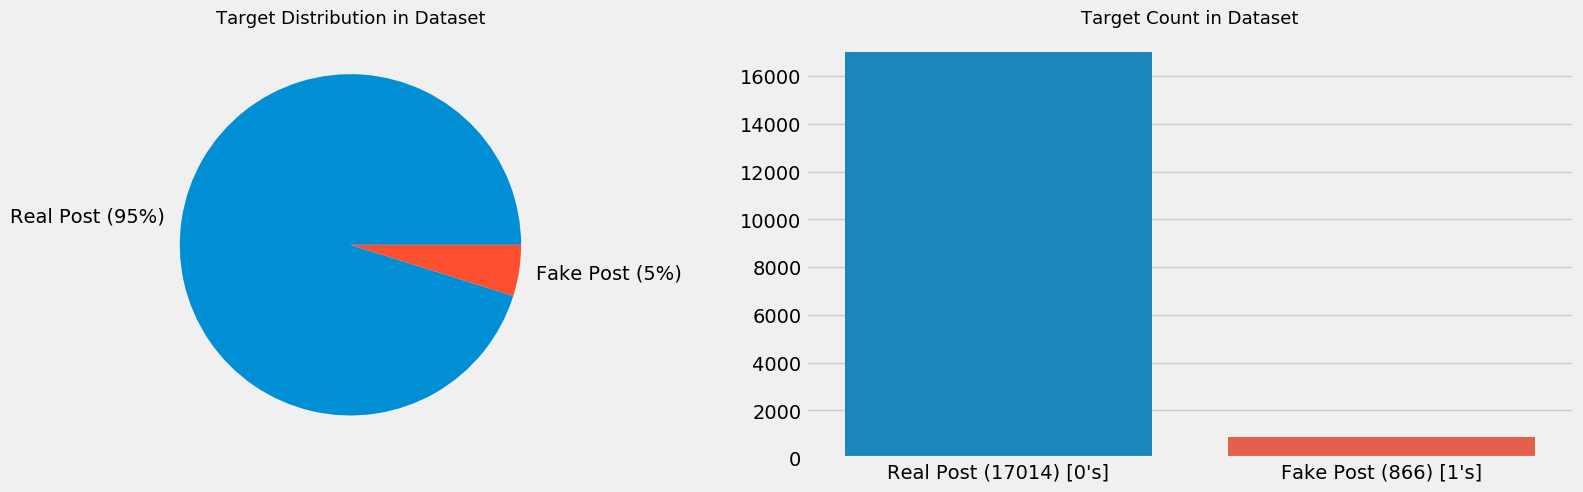

In [205]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
plt.tight_layout()

temp = data["fraudulent"].value_counts()
print(temp)
temp.plot(kind='pie', ax=axes[0], labels=['Real Post (95%)', 'Fake Post (5%)'])

sns.barplot(temp.index, temp, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post (17014) [0's]", "Fake Post (866) [1's]"])

axes[0].set_title('Target Distribution in Dataset', fontsize=13)
axes[1].set_title('Target Count in Dataset', fontsize=13)

plt.show()

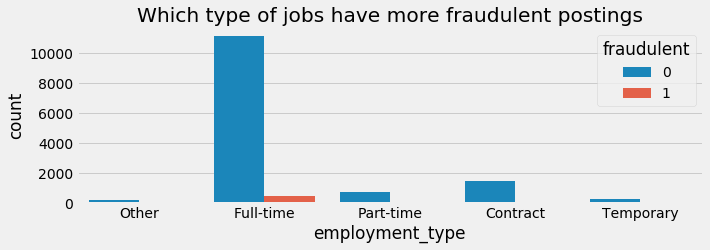

In [206]:
plt.figure(1,figsize=(10,3))
plt.tight_layout()

sns.countplot(hue=df.fraudulent,x=df.employment_type);
plt.title('Which type of jobs have more fraudulent postings');

#axes[0].set_title('Which type of jobs have more fraudulent postings');


# Since it is Imbalanced Dataset, we can balance it using Oversampling or Undersampling Techniques.
But for this project, I leave it to you

(0, 800)

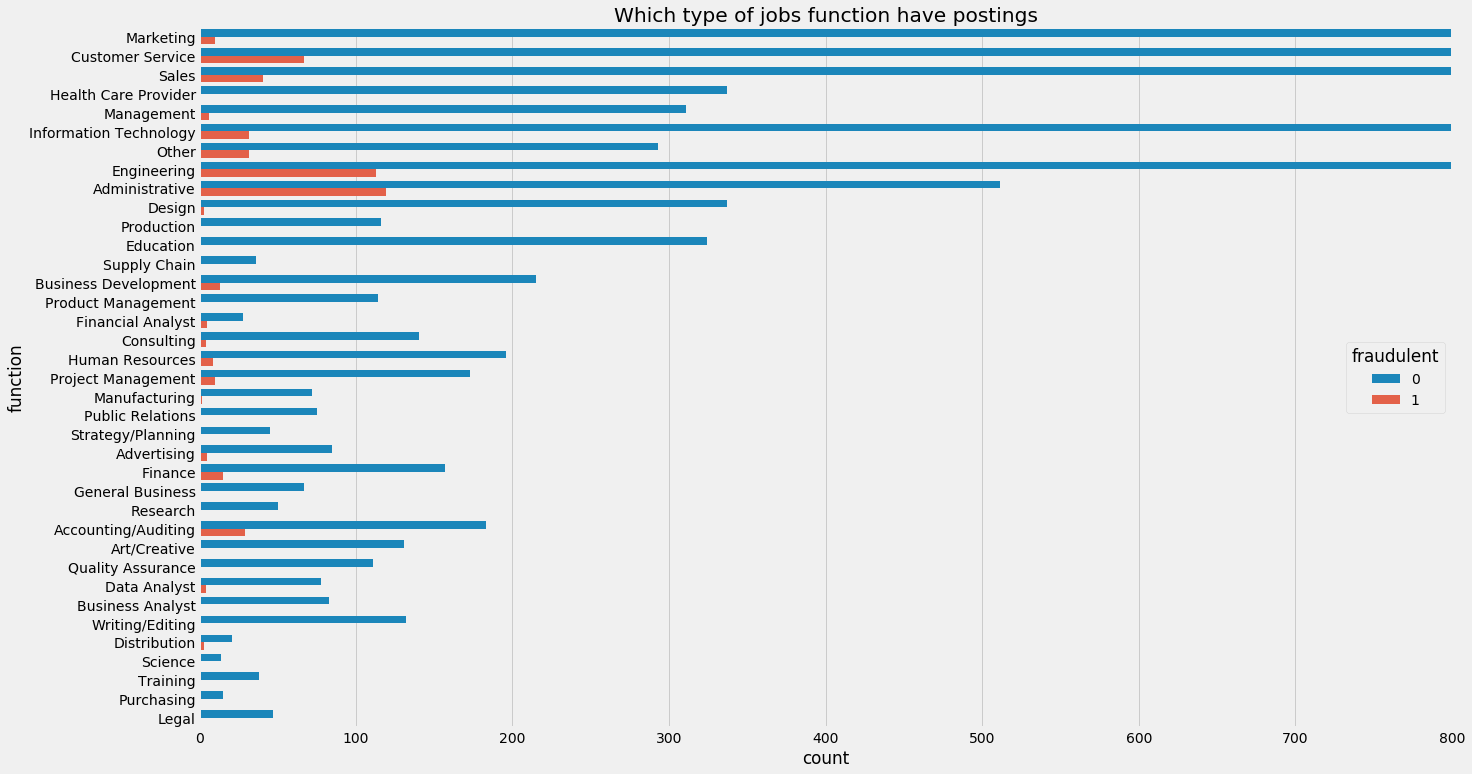

In [208]:
plt.figure(1,figsize=(20,12))
sns.countplot(y=df.function,hue=df.fraudulent);
plt.title('Which type of jobs function have postings');
plt.xlim(0,800)

First,we will do very basic analysis,that is character level,word level and sentence level analysis.

## Number of characters
Let's compare the number of character in the fake post and real post and try to distinguish pattern in the fake and real post based on number of charater used in the post.
#### Company profile

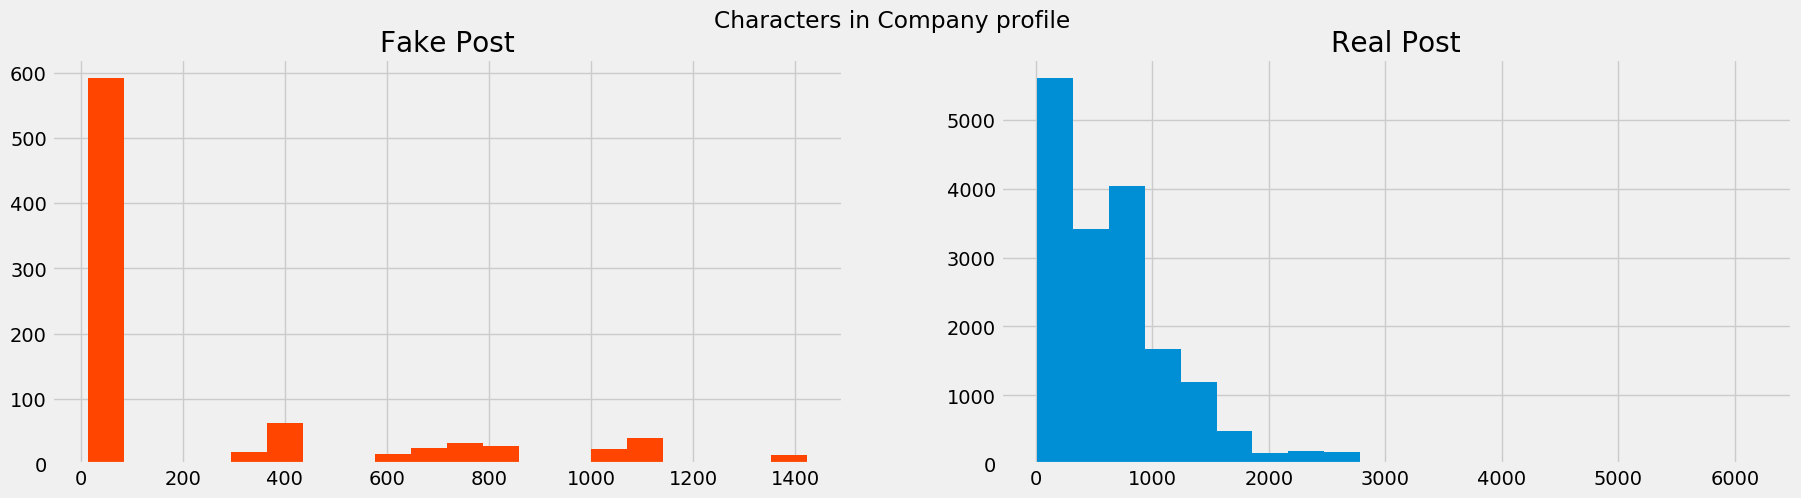

In [209]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(20, 5), dpi=100)
length=data[data["fraudulent"]==1]['company_profile'].str.len()
ax1.hist(length,bins = 20, color='orangered')
ax1.set_title('Fake Post')

length=data[data["fraudulent"]==0]['company_profile'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')

fig.suptitle('Characters in Company profile')
plt.show()

We can see that **fake post has less characters** in the company profile while **real post has more charaters.**

Description

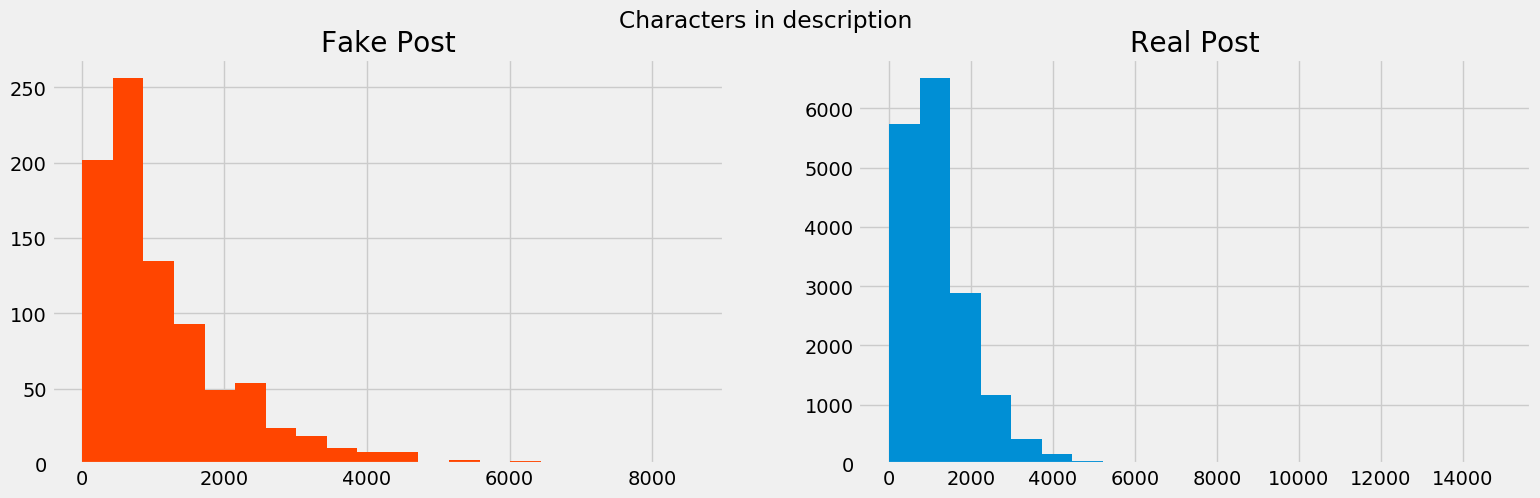

In [210]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=data[data["fraudulent"]==1]['description'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=data[data["fraudulent"]==0]['description'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in description')
plt.show()

The distribution of charaters in description of the fake and real post are similar but some fake post reach to 6000 to 6500 characters. 

Requirements

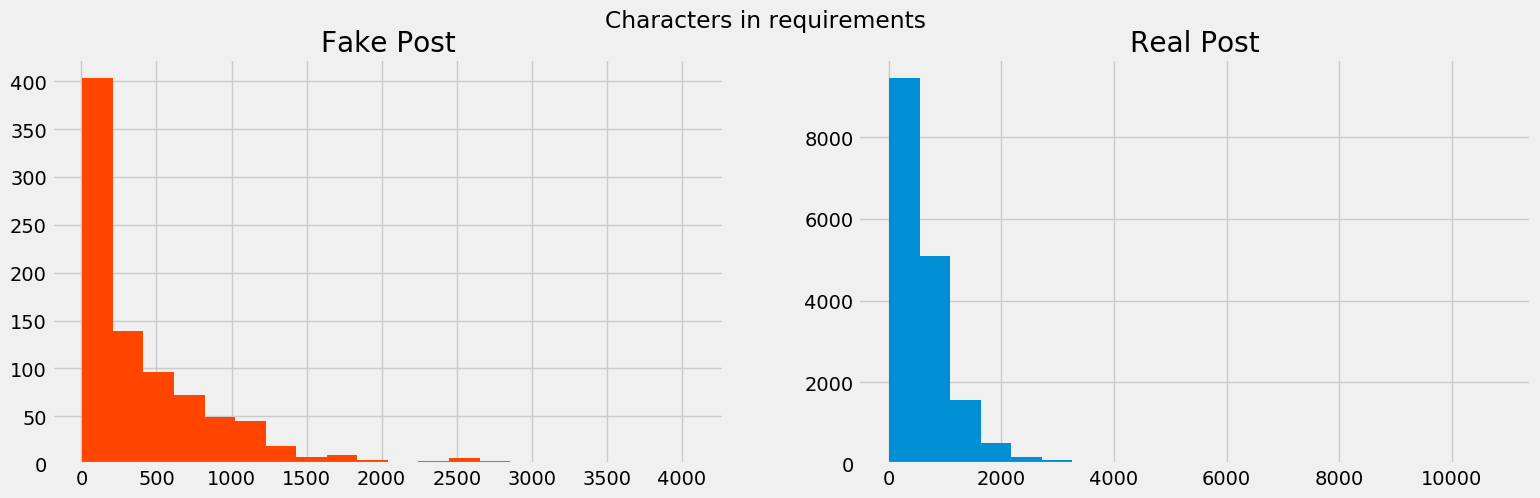

In [216]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=data[data["fraudulent"]==1]['requirements'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=data[data["fraudulent"]==0]['requirements'].str.len()
ax2.hist(length,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in requirements')
plt.show()

The distribution of charaters in requirements of the fake and real post are similar.

#### Benefits

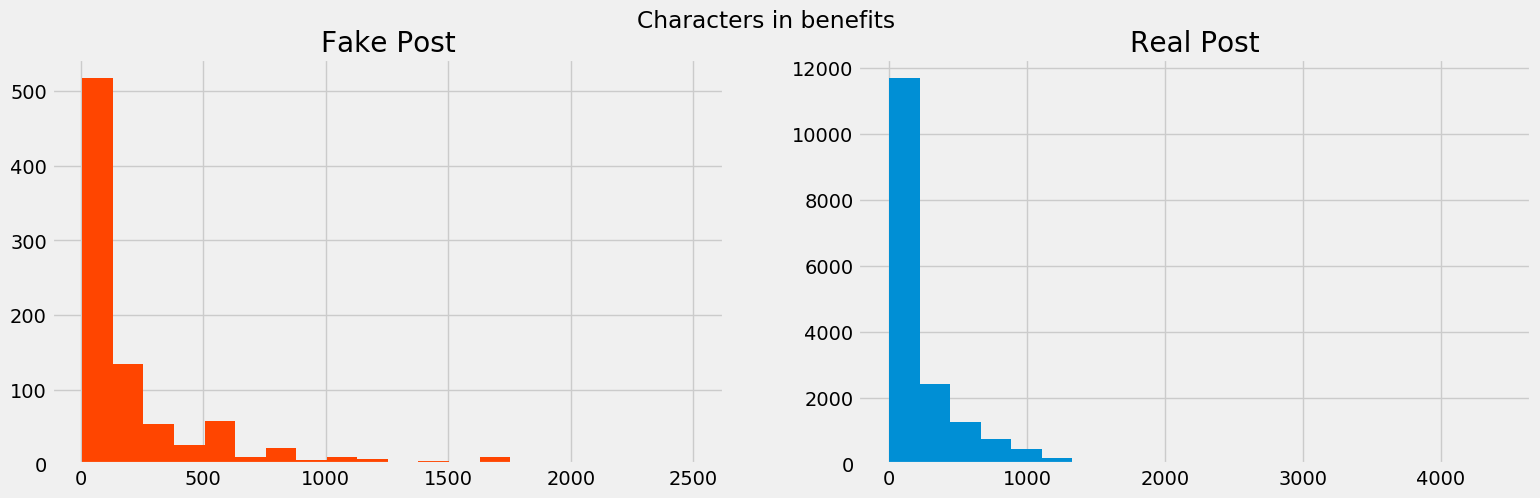

In [217]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=data[data["fraudulent"]==1]['benefits'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=data[data["fraudulent"]==0]['benefits'].str.len()
ax2.hist(length,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in benefits')
plt.show()

The distribution of charaters in requirements of the fake and real post is same around 1500 to 1800.

## Number of words
Let's compare the number of words in the fake post and real post and try to distinguish pattern in the fake and real post based on number of words used in the post.

#### Company Profile

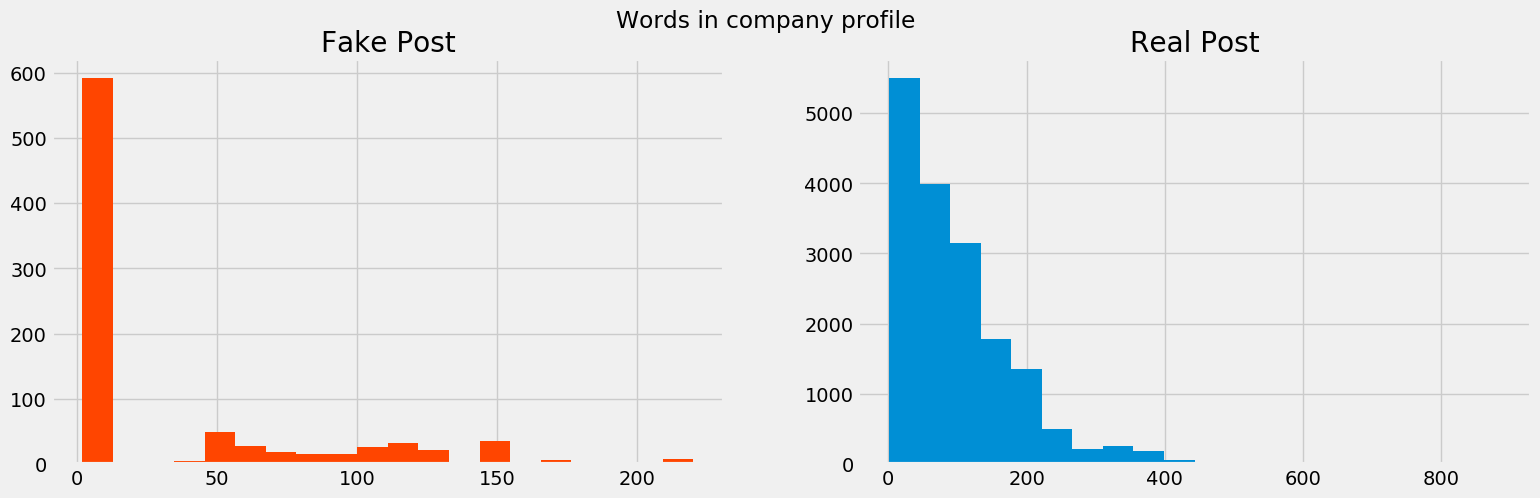

In [219]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=data[data["fraudulent"]==1]['company_profile'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=data[data["fraudulent"]==0]['company_profile'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in company profile')
plt.show()

Pattern of words in company profile is same as character in company profile. **fake post has less words** in the company profile while **real post has more words.**

#### Description

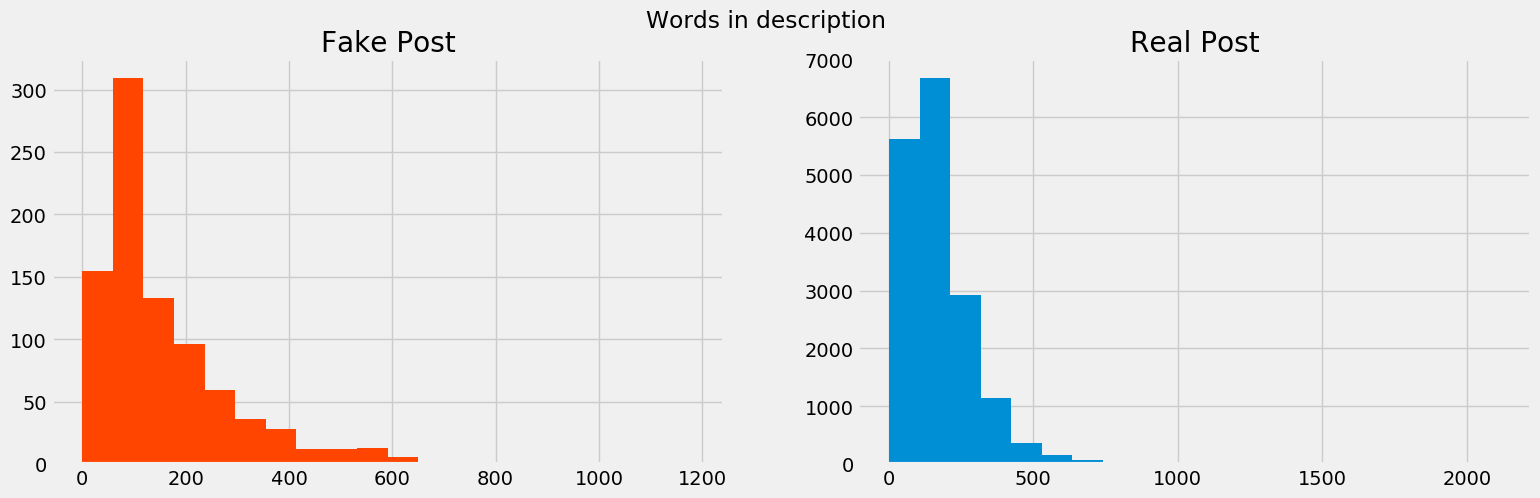

In [220]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=data[data["fraudulent"]==1]['description'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=data[data["fraudulent"]==0]['description'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in description')
plt.show()

Hmm!! Both the post has similar distribution of words in description.

#### Requirements

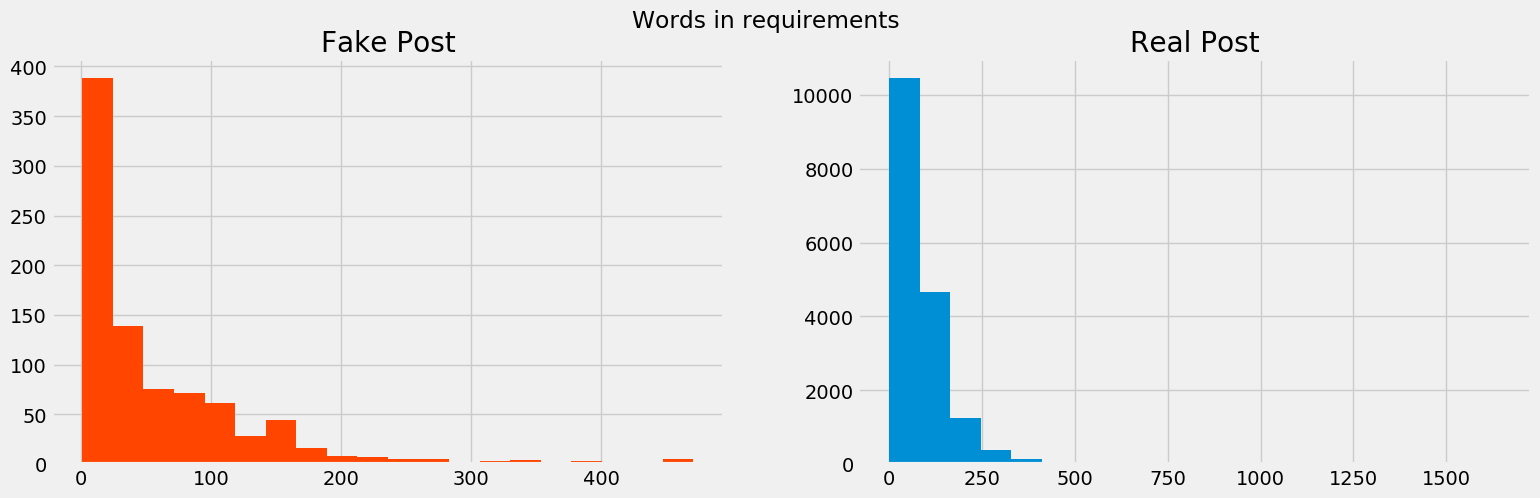

In [221]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=data[data["fraudulent"]==1]['requirements'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=data[data["fraudulent"]==0]['requirements'].str.split().map(lambda x: len(x))
ax2.hist(num,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in requirements')
plt.show()

The distribution of words in requirements of the fake and real post are similar.

#### Benefits

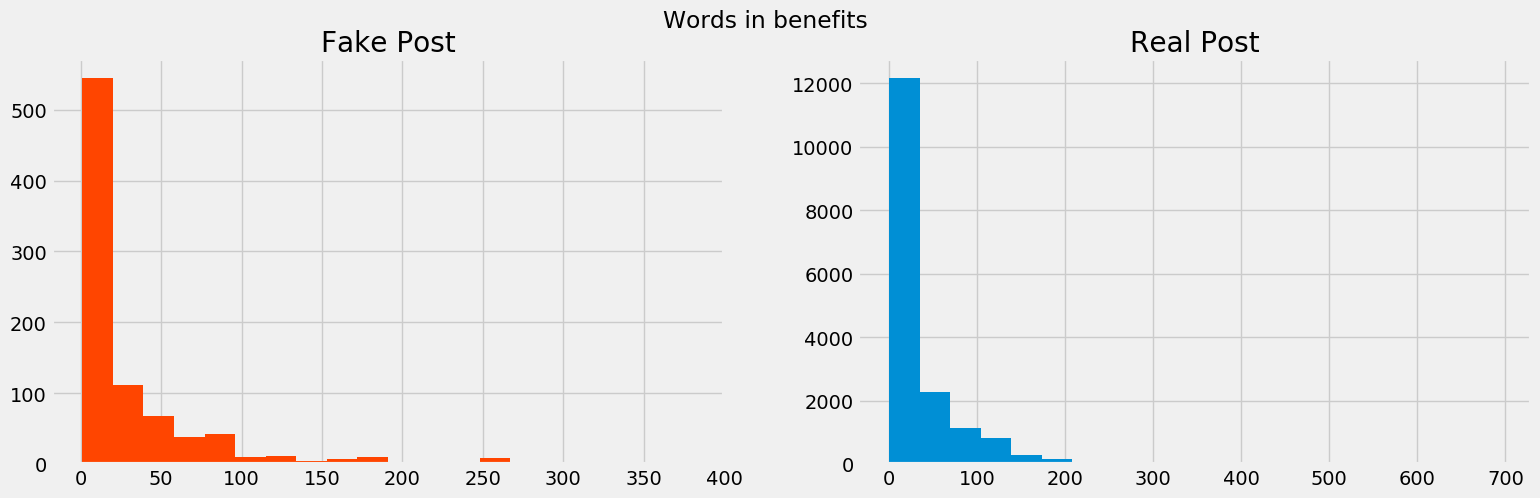

In [222]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=data[data["fraudulent"]==1]['benefits'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=data[data["fraudulent"]==0]['benefits'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in benefits')
plt.show()

The distribution of words in benefits of the fake and real post are also similar.

# Data preprocessing

In [223]:
data.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [289]:
"""Concate the text data for preprocessing and modeling"""

text = data[data.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = df['fraudulent']

print(len(text))
print(len(target))

17880
17880


In [225]:
text[:5]

0    Marketing Intern,We're Food52, and we've creat...
1    Customer Service - Cloud Video Production,90 S...
2    Commissioning Machinery Assistant (CMA),Valor ...
3    Account Executive - Washington DC,Our passion ...
4    Bill Review Manager,SpotSource Solutions LLC i...
dtype: object

Ngrams Analysis

Most common unigrams exist in **both classes** are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about target.

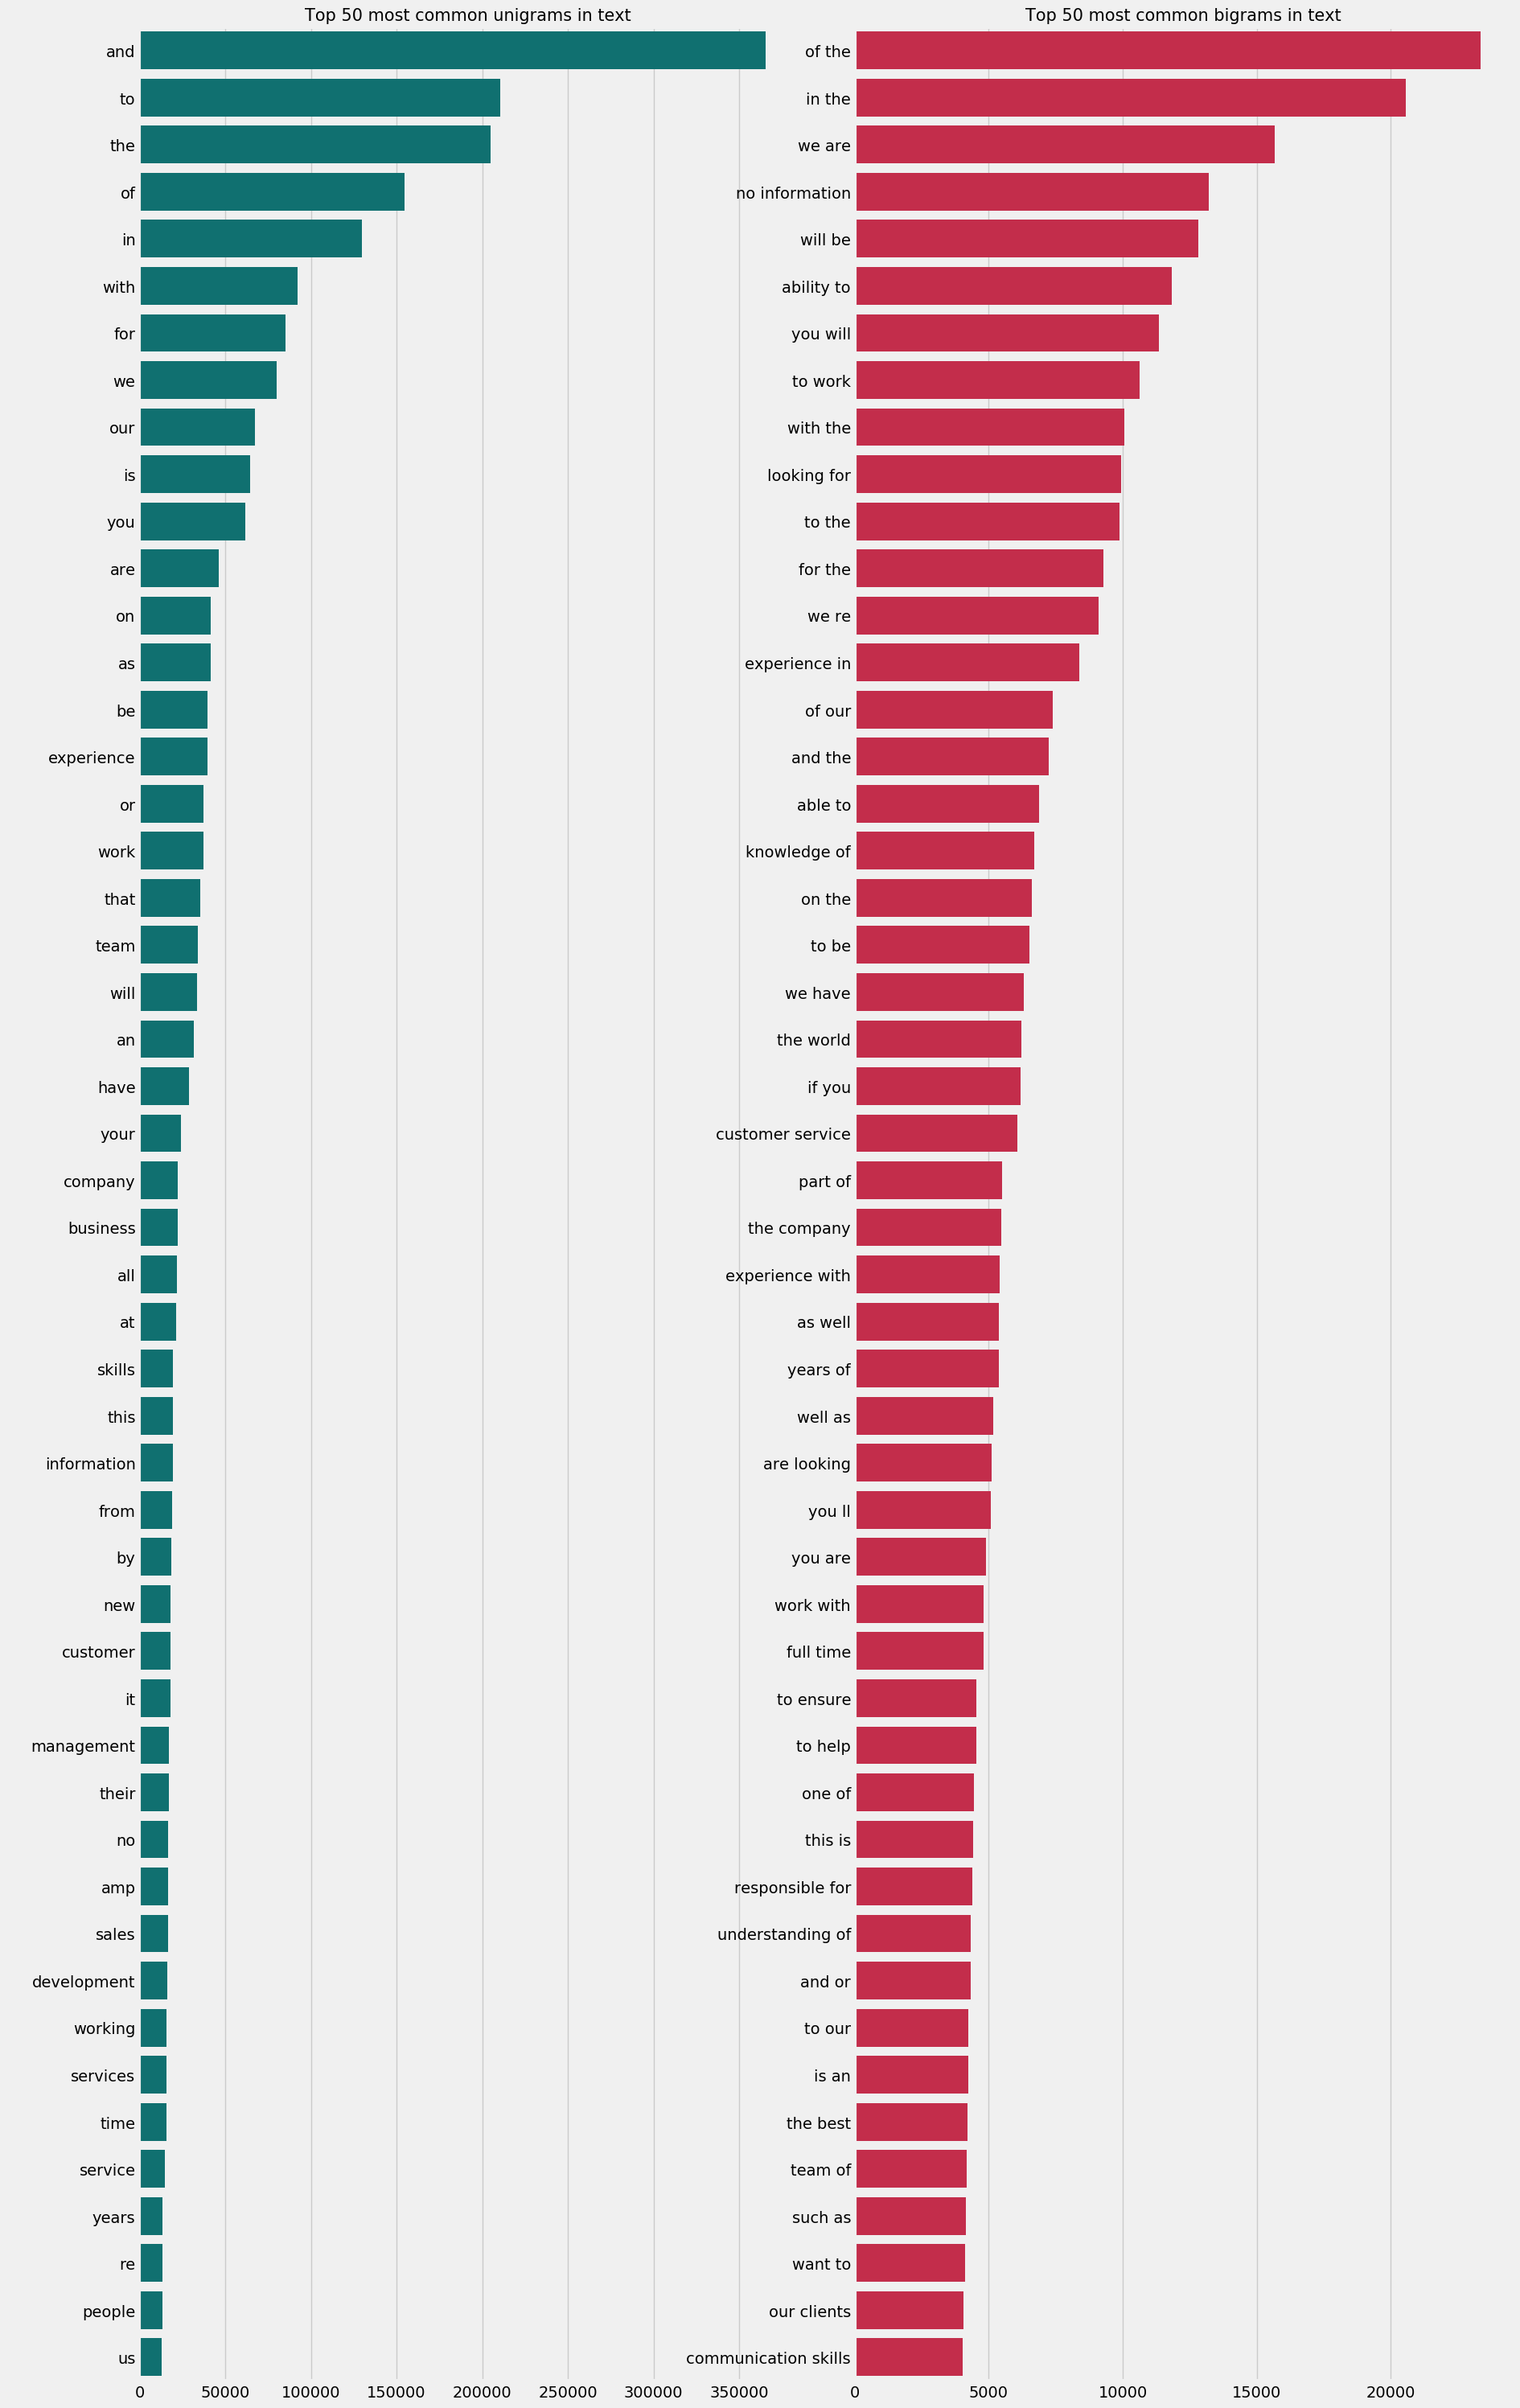

In [226]:
def get_top_tweet_unigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

top_unigrams=get_top_tweet_unigrams(text)[:50]
x,y=map(list,zip(*top_unigrams))
sns.barplot(x=y,y=x, ax=axes[0], color='teal')


top_bigrams=get_top_tweet_bigrams(text)[:50]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x, ax=axes[1], color='crimson')


axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('Top 50 most common unigrams in text', fontsize=15)
axes[1].set_title('Top 50 most common bigrams in text', fontsize=15)

plt.show()

## Text cleaning

In [290]:
%%time
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
text = text.apply(lambda x: clean_text(x))
text.head(3)

Wall time: 8.35 s


0    marketing internwere  and weve created a groun...
1    customer service  cloud video  seconds the wor...
2    commissioning machinery assistant cmavalor ser...
dtype: object

## Tokenizer

In [291]:
%%time
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# appling tokenizer5
text = text.apply(lambda x: tokenizer.tokenize(x))
text.head(3)

Wall time: 2.17 s


0    [marketing, internwere, and, weve, created, a,...
1    [customer, service, cloud, video, seconds, the...
2    [commissioning, machinery, assistant, cmavalor...
dtype: object

## Remove StopWords

In [292]:
%%time

from nltk.corpus import stopwords
stop = stopwords.words('english')
text= text.apply(lambda x: [item for item in x if item not in stop])


Wall time: 9.9 s


## Combine clean text

In [293]:
%%time
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

text = text.apply(lambda x : combine_text(x))

Wall time: 185 ms


In [313]:
X=text
y=target

#### Splitiing Training and Testing Data

In [294]:
# from sklearn import preprocessing
# from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(text, target, test_size = .20, random_state = 101)

## General Model

In [320]:
# Stratified k-fold cross-validation with an imbalanced dataset
def classifier(model, x_train, y_train):    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    auc_scores = []   
    count = 0
    # enumerate the splits and summarize the distributions
    for train_ix, test_ix in kfold.split(x_train, y_train):
        print('Fold {}'.format(count + 1))
        train_X, test_X = text[train_ix], text[test_ix]
        train_y, test_y = target[train_ix], target[test_ix]

        # Appling Count Vectorizer
        count_vectorizer = CountVectorizer()
        train_X_vec = count_vectorizer.fit_transform(train_X)
        test_X_vec = count_vectorizer.transform(test_X)

        model.fit(train_X_vec, train_y)
        preds = model.predict(test_X_vec)

        auc = roc_auc_score(test_y, preds)
        print('{} AUC: {}'.format(count+1, auc))
        auc_scores.append(auc)

        count += 1

    print('AUC mean score = {:.6f}'.format(np.mean(auc_scores)))
    print('AUC std score = {:.6f}'.format(np.std(auc_scores)))
    
    count_vectorizer = CountVectorizer()
    x_train = count_vectorizer.fit_transform(x_train)
    model.fit(x_train,y_train)

#### Logistic Regression
Accuracy: 84.6%

In [321]:
lr = LogisticRegression(C=0.1, solver='lbfgs', max_iter = 1000)
classifier(lr, X, y)

Fold 1
1 AUC: 0.8605370303999023
Fold 2
2 AUC: 0.8346723988863957
Fold 3
3 AUC: 0.8454984466273384
Fold 4
4 AUC: 0.8600962428594967
Fold 5
5 AUC: 0.8318636096413873
AUC mean score = 0.846534
AUC std score = 0.012141


#### Decision Tree
Accuracy: 84.4%

In [322]:
dt = DecisionTreeClassifier(criterion='entropy')
classifier(dt, X, y)

Fold 1
1 AUC: 0.8645058168667905
Fold 2
2 AUC: 0.8149320813495062
Fold 3
3 AUC: 0.8515242416161191
Fold 4
4 AUC: 0.8619095018166562
Fold 5
5 AUC: 0.8274544385655497
AUC mean score = 0.844065
AUC std score = 0.019578


#### Random Forest
Accuracy: 81.5%

In [323]:
rf = RandomForestClassifier(n_estimators=500,bootstrap = True)
classifier(rf, X, y)

Fold 1
1 AUC: 0.8294797687861272
Fold 2
2 AUC: 0.7890173410404624
Fold 3
3 AUC: 0.8121387283236994
Fold 4
4 AUC: 0.823699421965318
Fold 5
5 AUC: 0.8247126436781609
AUC mean score = 0.815810
AUC std score = 0.014558
